In [10]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from  datetime import date, timedelta

In [11]:
date_now = str(date.today() - timedelta(days=2))
df_apple_to_csv = yf.download("AAPL", start="2020-01-01", end=date_now)
df_microsoft_to_csv = yf.download("MSFT", start="2020-01-01", end=date_now)
df_amazon_to_csv = yf.download("AMZN", start="2020-01-01", end=date_now)
df_nvidia_to_csv = yf.download("NVDA", start="2020-01-01", end=date_now)

apple_path = 'datasets/apple.csv'
microsoft_path = 'datasets/microsoft.csv'
amazon_path = 'datasets/amazon.csv'
nvidia_path = 'datasets/nvidia.csv'

df_apple_to_csv.to_csv(apple_path)
df_microsoft_to_csv.to_csv(microsoft_path)
df_amazon_to_csv.to_csv(amazon_path)
df_nvidia_to_csv.to_csv(nvidia_path)

df_apple = pd.read_csv(apple_path)
df_microsoft = pd.read_csv(microsoft_path)
df_amazon = pd.read_csv(amazon_path)
df_nvidia = pd.read_csv(nvidia_path)

C:\Users\acer\AppData\Local\Temp\ipykernel_4440\165612693.py:2: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed
C:\Users\acer\AppData\Local\Temp\ipykernel_4440\165612693.py:3: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed
C:\Users\acer\AppData\Local\Temp\ipykernel_4440\165612693.py:4: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed
C:\Users\acer\AppData\Local\Temp\ipykernel_4440\165612693.py:5: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


In [12]:
df_apple['Date'] = df_apple['Price']
df_apple = df_apple.drop(index=[0,1], columns='Price')

df_microsoft['Date'] = df_microsoft['Price']
df_microsoft = df_microsoft.drop(index=[0,1], columns='Price')

df_amazon['Date'] = df_amazon['Price']
df_amazon = df_amazon.drop(index=[0,1], columns='Price')

df_nvidia['Date'] = df_nvidia['Price']
df_nvidia = df_nvidia.drop(index=[0,1], columns='Price')

In [13]:
#INITIAL
dfs = [df_apple, df_amazon, df_microsoft, df_nvidia]
window = 14
short_period = 12
long_period = 26
signal_line_period = 9
stocks = ['AAPL', 'AMZN', 'MSFT', 'NVDA']
labels = ['WW', 'M', 'Y', 'AT']

In [14]:
#CONVERTING TO CORRECT FEATURE TYPES
def convert_type(df):
    df['Close'] = df['Close'].astype(float)
    df['High'] = df['High'].astype(float)
    df['Low'] = df['Low'].astype(float)
    df['Open'] = df['Open'].astype(float)
    df['Volume'] = df['Volume'].astype(int)
    df['Date'] = pd.to_datetime(df['Date'])

In [15]:
#FEATURE ENGINEERING
def engineer_features(df):
    df['Price Change'] = df['Close'].diff().fillna(0)
    
    df['Gain'] = df.loc[df['Price Change'] > 0, 'Price Change']
    df['Loss'] = -df.loc[df['Price Change'] < 0, 'Price Change']
    df['Gain'] = df['Gain'].fillna(0)
    df['Loss'] = df['Loss'].fillna(0)
    
    df['Average Gain'] = df['Gain'].rolling(window=window).mean().fillna(0)
    df['Average Loss'] = df['Loss'].rolling(window=window).mean().fillna(0)
    
    df['RS'] = df['Average Gain'] / df['Average Loss']
    df['RSI'] = 100 - (100 / (1 + df['RS']))
    
    df['Short EMA'] = df['Close'].ewm(span=short_period,adjust=False).mean()
    df['Long EMA'] = df['Close'].ewm(span=long_period, adjust=False).mean()
    
    df['MACD'] = df['Short EMA'] - df['Long EMA']
    df['Signal Line'] = df['MACD'].ewm(span=signal_line_period, adjust=False).mean()
    df['MACD Histogram'] = df['MACD'] - df['Signal Line']
    return df

In [16]:
#DROPPING NULL AND UNIMPORTANT COLUMNS/ROWS
def drop_features_and_na(df):
    df = df.drop(columns=['Gain', 'Loss'])
    df = df.dropna()
    return df

In [ ]:
#PRINTING SEABORN PLOTS
def print_all_plots(datas, stock, labels):
    for i in range(len(datas)):
        plt.figure(figsize=(10.5,3.5))
        sns.lineplot(data=datas[i], x='Date', y='Close', errorbar=None)
        sns.despine()
        plt.xlabel(xlabel="")
        plt.ylabel(ylabel="")
        plt.savefig(f"../../frontend/public/svg_visuals/{stock}_{labels[i]}.svg")
        plt.close()
        
        #Sub chart
        plt.figure(figsize=(6.5,3.5))
        sns.lineplot(data=datas[i], x='Date', y='Close', errorbar=None)
        sns.despine()
        plt.xlabel(xlabel="")
        plt.ylabel(ylabel="")
        plt.savefig(f"../../frontend/public/svg_visuals/{stock}_{labels[i]}_m.svg")
        plt.close()
        
        fig = px.line(data_frame=datas[i], x='Date', y='Close')
        fig.update_layout(width=1920, height=1080)
        fig.write_html(f"../../frontend/public/chart_visuals/{stock}_{labels[i]}.html")

AAPL is good to go!
AMZN is good to go!
MSFT is good to go!
NVDA is good to go!


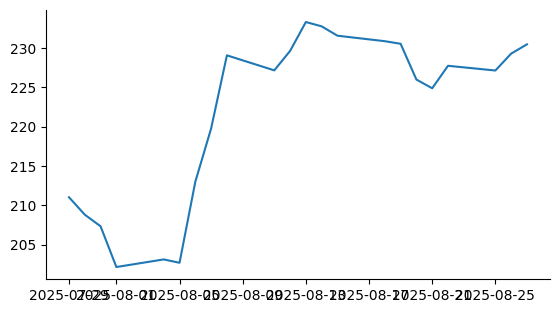

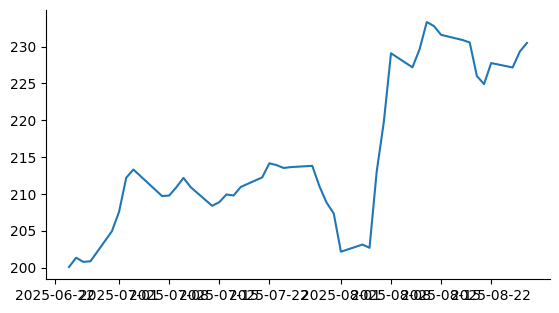

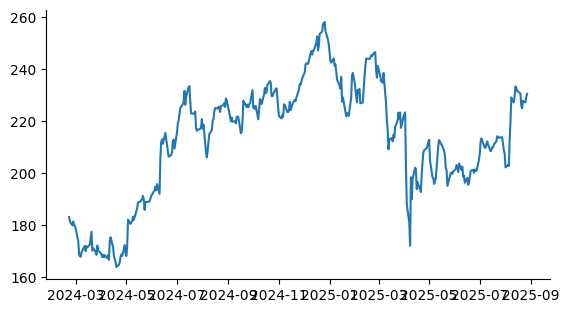

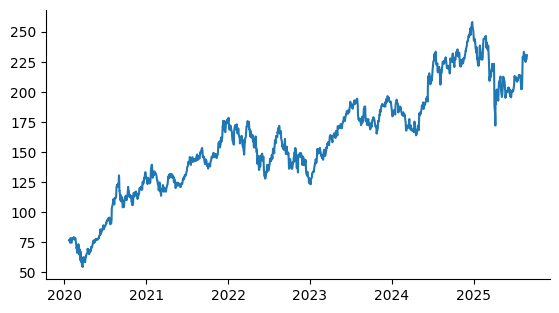

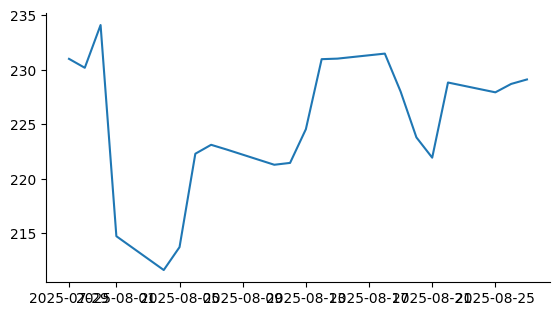

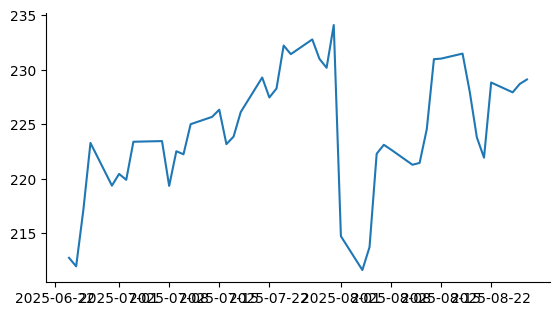

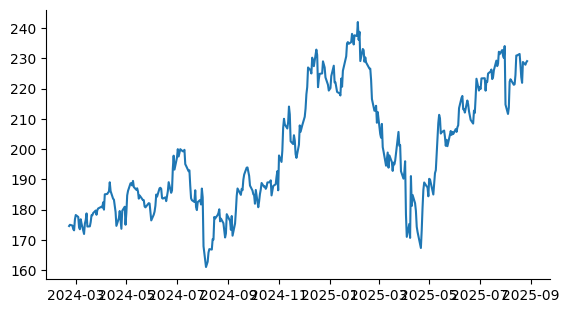

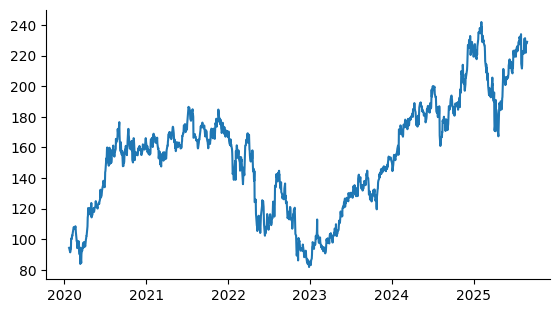

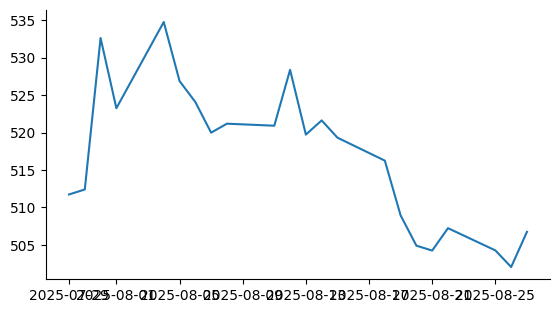

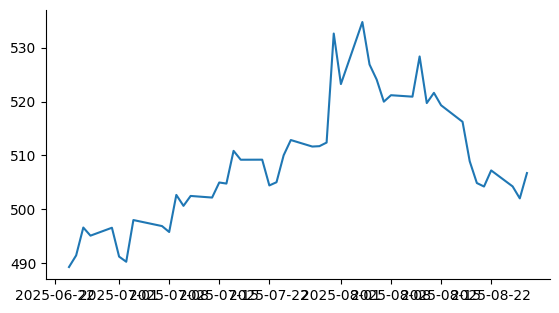

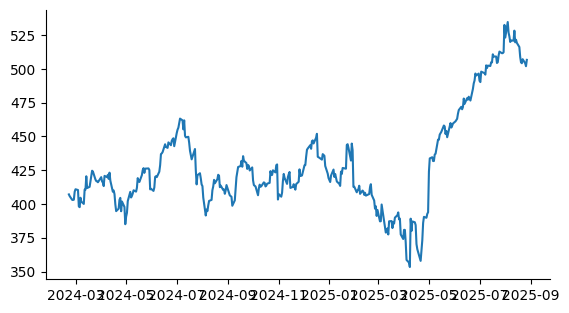

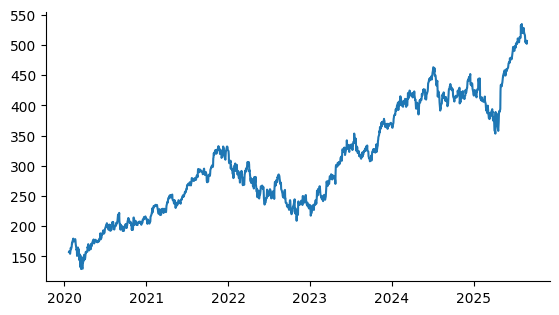

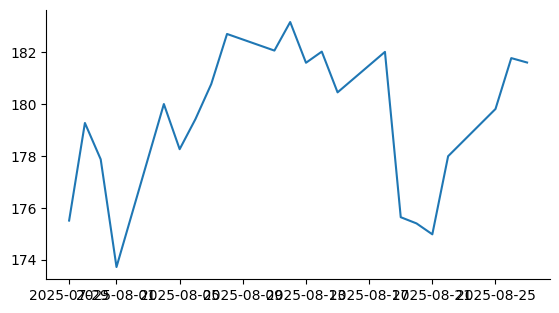

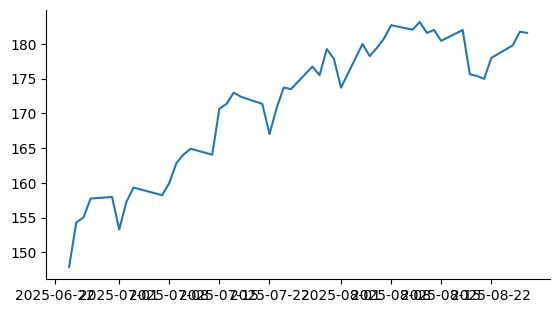

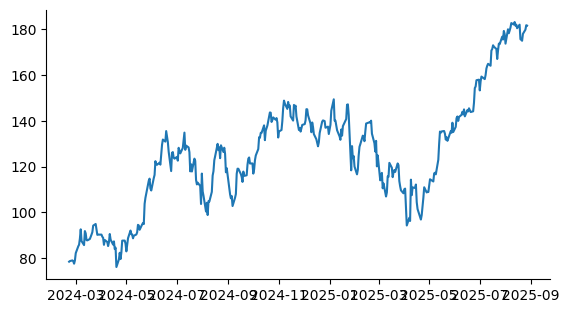

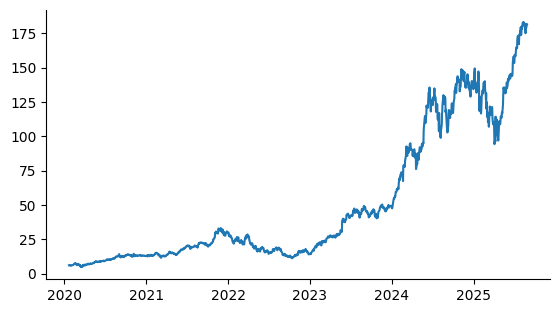

In [18]:
for i,df in enumerate(dfs):
    convert_type(df)
    df = engineer_features(df)
    df = drop_features_and_na(df)
    
    week = df.loc[len(df) - 7::, ['Date','Close']]
    month = df.loc[len(df) - 31::, ['Date','Close']]
    year = df.loc[len(df) - 365::, ['Date','Close']]
    all_time = df
    datas = [week, month, year, all_time]
    
    print_all_plots(datas=datas, stock=stocks[i], labels=labels)
    
    print(f"{stocks[i]} is good to go!")